In [2]:
import matplotlib
import matplotlib.pyplot as plt

import jax
import jax.numpy as np
from jax.random import PRNGKey

import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

import pandas as pd

from models import SEIR_stochastic, plot_samples, plot_forecast, plot_R0
import util

# Run Inference

In [45]:
data = util.load_state_data()

#places = state_data.keys()
#places = ['Italy', 'US', 'WA', 'NY', 'MA']
#places = ['NY', 'MA', 'WA', 'AK', 'WV']
#places = ['US']
#places = ['NY']
#places = ['NY', 'WA']
places = ['AL']

save = True
for place in places:
    util.run_place(data, place, use_hosp=True, save=save, num_warmup=1000, num_samples=1000)


******* AL *********
Running MCMC


sample: 100%|██████████| 2000/2000 [04:19<00:00,  7.71it/s, 1023 steps of size 5.02e-03. acc. prob=0.95]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
         E0      0.68      0.91      0.39      0.00      1.64    626.00      1.00
         I0      0.23      0.26      0.15      0.00      0.54    619.34      1.00
    beta[0]      2.17      1.11      1.96      0.68      3.65    179.00      1.01
    beta[1]      2.28      1.16      2.05      0.80      3.81    280.91      1.00
    beta[2]      2.47      1.24      2.16      0.71      4.08    442.92      1.00
    beta[3]      2.69      1.33      2.42      0.88      4.35    554.59      1.00
    beta[4]      2.97      1.43      2.66      1.06      4.89    628.86      1.00
    beta[5]      3.29      1.51      2.94      1.29      5.47    664.95      1.00
    beta[6]      3.68      1.66      3.35      1.45      6.18    676.91      1.00
    beta[7]      3.95      1.73      3.56      1.39      6.25    621.71      1.00
    beta[8]      4.08      1.77      3.73      1.70      6.50    555.06      1.00
    beta[9]    

In [33]:
%debug

> /Users/sheldon/projects/covid/lib/jax/jax/numpy/lax_numpy.py(1179)broadcast_to()
   1177     if nlead < 0 or not onp.all(compatible):
   1178       msg = "Incompatible shapes for broadcasting: {} and requested shape {}"
-> 1179       raise ValueError(msg.format(arr_shape, shape))
   1180     diff, = onp.where(onp.not_equal(shape[nlead:], arr_shape))
   1181     new_dims = tuple(range(nlead)) + tuple(nlead + diff)

ipdb> up
> /Users/sheldon/projects/covid/lib/jax/jax/ops/scatter.py(61)_scatter_impl()
     59 
     60   # Broadcast `y` to the slice output shape.
---> 61   y = np.broadcast_to(y, tuple(indexer.slice_shape))
     62   # Collapse any `None`/`np.newaxis` dimensions.
     63   y = np.squeeze(y, axis=indexer.newaxis_dims)

ipdb> up
> /Users/sheldon/projects/covid/lib/jax/jax/ops/scatter.py(48)_scatter_update()
     46   # is more or less a transpose of the gather equivalent.
     47   treedef, static_idx, dynamic_idx = np._split_index_for_jit(idx)
---> 48   return _scatter_im

ipdb> up
> /Users/sheldon/projects/covid/lib/jax/jax/ops/scatter.py(240)index_update()
    238          [1., 1., 1., 6., 6., 6.]], dtype=float32)
    239   """
--> 240   return _scatter_update(x, idx, y, lax.scatter)
    241 
    242 def segment_sum(data, segment_ids, num_segments=None):

ipdb> up
> /Users/sheldon/projects/covid/models.py(101)masked_sample()
     99     if np.any(~observed):
    100         n_unobs = np.sum(~observed)
--> 101         y = jax.ops.index_update(y, ~observed, numpyro.sample(name + "_unobs", d, sample_shape=(n_unobs,)))
    102 
    103     numpyro.deterministic(name, y)

ipdb> p obs
array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan])
ipdb> p type(y)
<class 'jax.interpreters.xla.DeviceArray'>
ipdb> p y
DeviceArray([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
             0., 0., 0., 0., 0., 0., 0., 

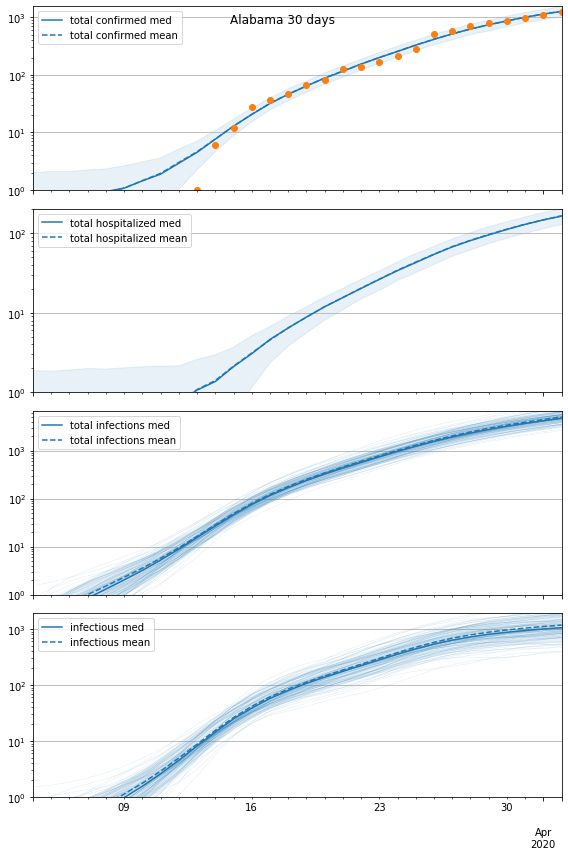

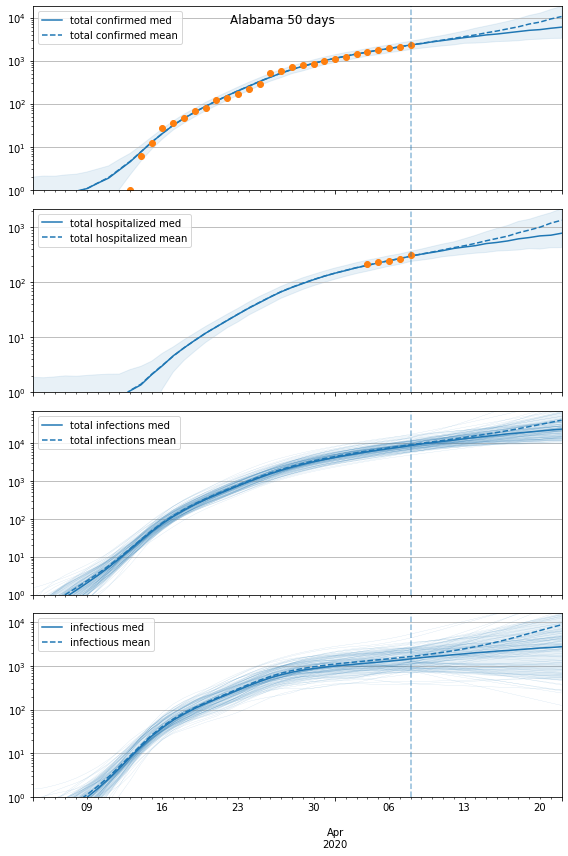

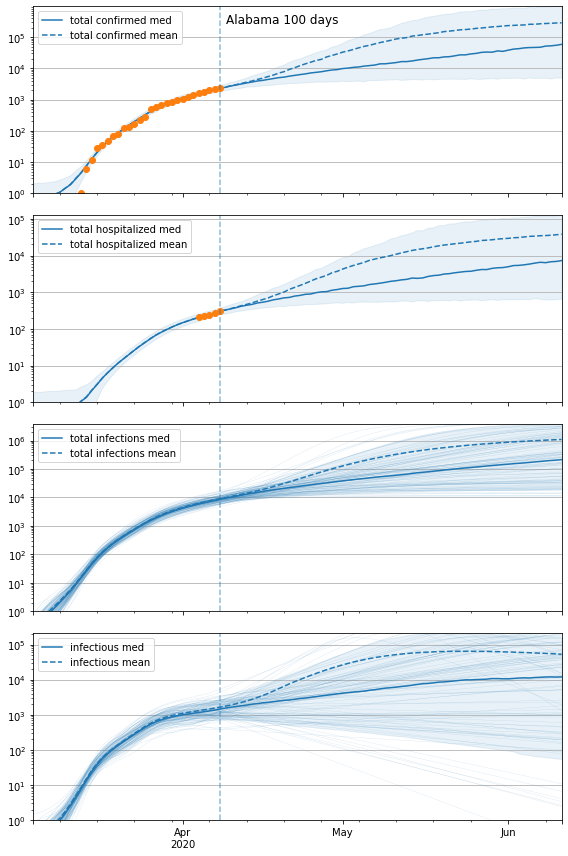

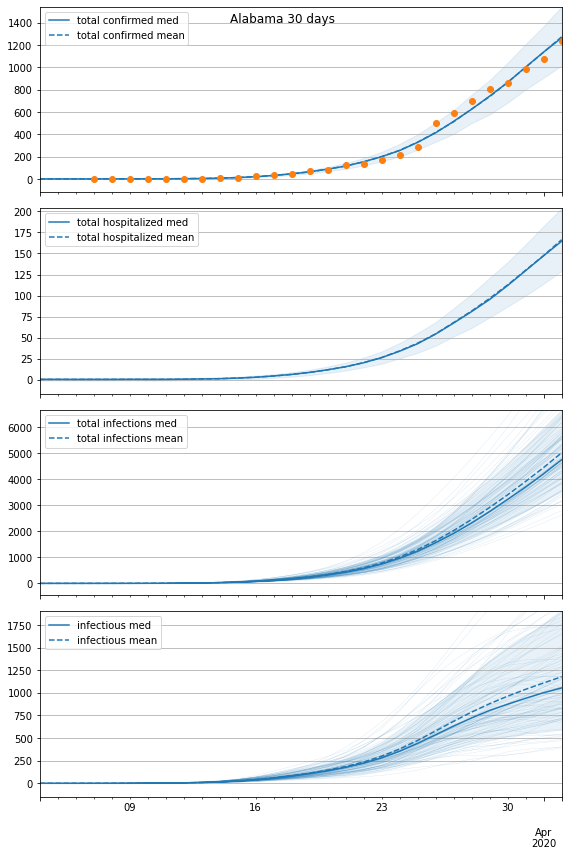

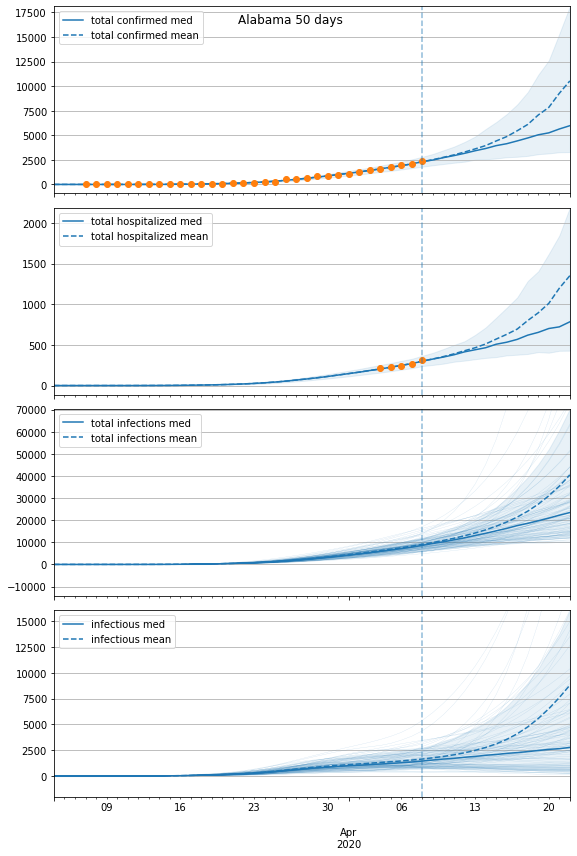

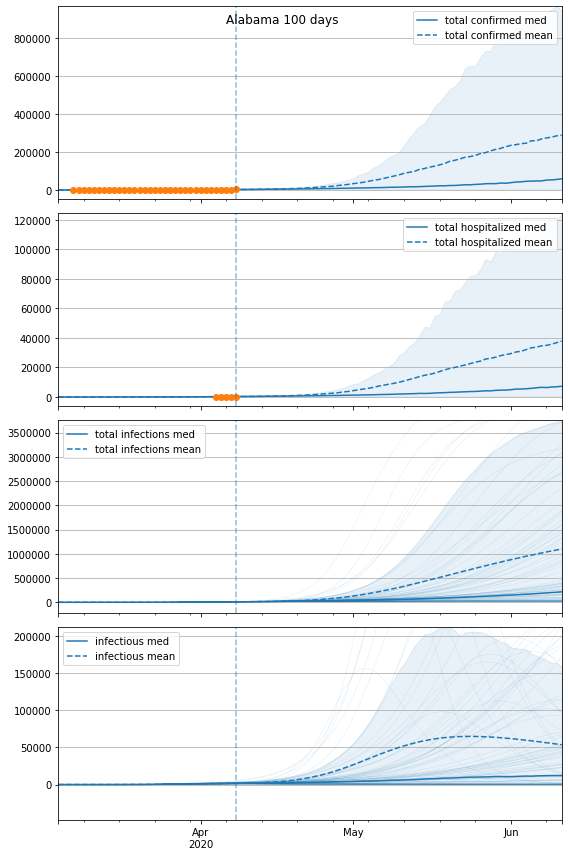

<Figure size 360x216 with 0 Axes>

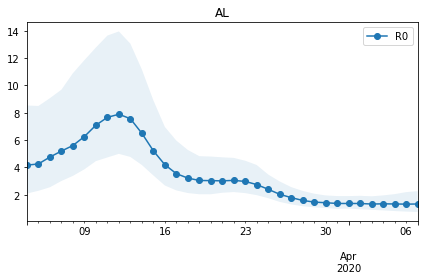

In [46]:
data = util.load_state_data()

start = '2020-03-04'
#places = ['Italy', 'US', 'WA', 'NY', 'MA']
#places = ['ID']
#places = ['NY']
#places = state_data.keys()
#places = ['AK']
#places = ['US']
#places = ['LA', 'NY']
#places = ['NY', 'MA', 'WA', 'AK', 'WV']
places = ['AL']
#places = ['NY']
#places = ['AZ']

use_hosp = True
save = True


# Inspect and Save Results 
for place in places:
    util.gen_forecasts(data, place, use_hosp=use_hosp, save=save)

0.1341772151898734

In [ ]:
import seaborn as sns

cols = ['gamma', 'beta0', 'sigma', 'det_rate']

def get_cols(d):
    return {k: v for k, v in d.items() if k in cols}

prior_df = pd.DataFrame(get_cols(prior_samples))
posterior_df = pd.DataFrame(get_cols(mcmc_samples))

prior_df['dist'] = 'prior'
posterior_df['dist'] = 'posterior'

# Visualize priors
fig, ax = plt.subplots(ncols=len(cols), figsize=(16,3))
for i in range(len(cols)):
    sns.kdeplot(prior_df[cols[i]], ax=ax[i], shade=True)
    ax[i].set_title(cols[i])
    plt.suptitle('Priors')
plt.show()
    

# Compare posterior to prior
df = pd.concat([prior_df, posterior_df])
g = sns.PairGrid(df, hue='dist', diag_sharey=False, vars=['beta0', 'gamma', 'sigma'])
g = g.map_diag(sns.kdeplot, shade=True)
g = g.map_upper(plt.scatter, s=0.1, alpha=0.5)
g = g.map_lower(sns.kdeplot, n_levels=5, shade=True, shade_lowest=False, alpha=0.6)
g = g.add_legend()
plt.show()

# Compare gamma and beta0 specifically
fig, ax = plt.subplots(figsize=(9,4), ncols=2)

xlim = [0, 6]
ylim = [0, 3]

for df, name, a in zip([prior_df, posterior_df], ['Prior', 'Posterior'], ax):
    sns.kdeplot(df['beta0'], 
                df['gamma'], 
                ax=a,
                shade=True, 
                shade_lowest=False)
    a.set_title(name)
    a.set_xlim(xlim)
    a.set_ylim(ylim)

plt.show()

In [ ]:
samples = post_pred_samples
X = np.concatenate((samples['x'], samples['x_future']), axis=1)

T = X.shape[1]
t = pd.date_range(start, freq='D', periods=T)
levels = 10

beta0 = mcmc_samples['beta0']
gamma = mcmc_samples['gamma']
inds = np.argsort(beta0)
level_inds = inds[np.linspace(0, len(I)-1, levels).astype('int32')]

fig, ax = plt.subplots(figsize=(12,14), nrows=5)


beta0_gamma = [f'({beta0[i]:.2f}, {gamma[i]:.2f})' for i in level_inds]

for col, name, a in zip([0, 1, 2, 3, 4], 
                       ['susceptible', 'exposed', 'infectious', 'removed', 'cum. infected'],
                       ax):

    X_levels = np.squeeze(X[level_inds,:,col].T)

    lines = []
    cmap = plt.cm.cool
    for i in range(levels):
        lines += a.plot(t, X_levels[:,i], color=cmap(i*30))

    a.set_title(name)
    
plt.legend(beta0_gamma)

plt.show()

In [ ]:
n = 50
for i in range(n):
    print(plt.cm.jet(i * n / 256))

In [ ]:
sns.distplot(df['beta0'], hist=False, kde_kws={'shade': True})

In [ ]:
from compartment import SIRModel, SEIRModel

save = False

beta = mcmc_samples['beta0']
#gamma = np.broadcast_to(mcmc_samples['gamma'][:,None], beta.shape)
gamma = mcmc_samples['gamma']
plt.plot(beta, gamma, '.')
offset = (beta-gamma).mean()

plt.plot([0.+offset, gamma.max()+offset], [0., gamma.max()])
plt.xlabel('beta')
plt.ylabel('gamma')
plt.title('posterior over (beta, gamma)')
plt.legend(['samples', r'gamma = beta + ' + f'{offset:.2f}'])
if save:
    filename = f'figs/{place}_beta_gamma.pdf'
    plt.savefig(filename)
plt.show()


plt.hist(beta/gamma, bins=100)
plt.title('R_0')
plt.xlabel('beta/gamma')
R_0_mean = np.mean(beta/gamma)
print("R0:", R_0_mean)
if save:
    filename = f'figs/{place}_R0.pdf'
    plt.savefig(filename)
plt.show()


growth_rate = SEIRModel.growth_rate((mcmc_samples['beta0'], 
                                     mcmc_samples['sigma'],
                                     mcmc_samples['gamma']))
plt.hist(growth_rate, bins=100)
plt.title('growth rate')
if save:
    filename = f'figs/{place}_growth_rate.pdf'
    plt.savefig(filename)
plt.show()

plt.hist(mcmc_samples['det_rate'], bins=50)
plt.title('det. rate')
if save:
    filename = f'figs/{place}_growth_rate.pdf'
    plt.savefig(filename)
plt.show()


## Tests

In [23]:
def test_prior(i, log_scale=False, **kwargs):
    with numpyro.handlers.seed(rng_seed=i):
        beta, x, y, z, obs_rate, hosp_rate = SEIR_stochastic(**kwargs)
        
    T = len(x)
    ts = np.arange(T)
    
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    
    l1 = ax1.plot(ts, x[:,1:])    
    l2 = ax2.plot(ts, y, 'x', color='r')
    l3 = ax2.plot(ts, z, 'x', color='k')
        
    plt.legend(l1 + l2 + l3, ['I', 'R', 'C', 'y', 'hosp'])
    
    ax1.set_ylabel('compartment count')
    ax2.set_ylabel('observed cases')

    if log_scale:
        ax1.set_yscale('log')
        ax2.set_yscale('log')
    
    ylim = np.array(ax1.get_ylim())
    ax2.set_ylim(obs_rate * ylim )
    
    plt.show()

def test_prior_predictive():
    T = 100
    T_future = 100
    N = 1e6
    predictive = Predictive(SEIR_stochastic, 
                            posterior_samples = {}, 
                            num_samples=100)

    samples = predictive(PRNGKey(2), T=T, T_future=100, N=N, det_conc=200)

    plot_samples(samples, T=200, plot_fields=['I', 'y'])
    plt.title('Prior predictive')
    plt.yscale('log') 
    plt.show()
    
    return samples
    
run_tests = True
    
if run_tests:
    for i in range(5):
        test_prior(i, log_scale=False, T=100, T_future=100, N=1e8, use_hosp=True)
        
#    samples = test_prior_predictive()

hosp_rate 0.044563632


IndexError: Too many indices for array: 1 non-None/Ellipsis indices for dim 0.

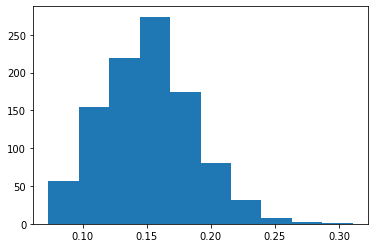

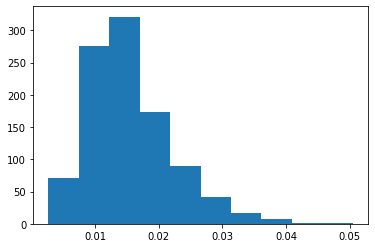

In [15]:
place = 'AZ'
prior_samples, mcmc_samples, post_pred_samples = util.load_samples(place)

plt.hist(prior_samples['hosp_rate'])
plt.show()

plt.hist(mcmc_samples['hosp_rate'])
plt.show()